# [E-16] 다음에 볼 영화 예측하기

이번 프로젝트는 고객이 바로 지금 원하는 것이 무엇인지를 예측하여 추천하는 Session-based Recommendation 개념을 익히고 실제로 모델을 구축해보는 것을 목표로 한다.

<hr>

## 1. Data Preprocess

### 1-1 Data Load

In [1]:
import pandas
import tensorflow
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

사용자 수는 6040개 아이템 수는 3706개이다.

### 1-2 Session Length

각 사용자가 대략 몇개의 리뷰 데이터를 갖고 있는지 확인해본다.

In [4]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
session_length.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

In [6]:
session_length.quantile(0.999)

1343.181000000005

사용자 별 데이터가 생각보다 많아 확인해보니 모든 Time에 대한 데이터가 그룹되어 있었다. 같은 사용자여도 각 시간에 대한 데이터를 구분해주기 위해 UserId와 Time을 고려하여 새로운 컬럼인 SessionId를 생성해주었다.

In [7]:
df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
df.reset_index(inplace = True)
df.drop(columns = 'ItemId', inplace = True)
df.rename(columns = {'index' : 'SessionId'}, inplace = True)
df

,SessionId,UserId,Time
0,0,1,978300019
1,1,1,978300055
2,2,1,978300103
3,3,1,978300172
4,4,1,978300275
...,...,...,...
471158,471158,6040,997454398
471159,471159,6040,997454429
471160,471160,6040,997454464
471161,471161,6040,997454486


In [8]:
data = pd.merge(data, df, on = ['UserId', 'Time'])
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


In [9]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [10]:
session_length.describe()

count    471163.000000
mean          2.122851
std           1.546899
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          30.000000
dtype: float64

In [11]:
session_length.quantile(0.999)

10.0

<AxesSubplot:>

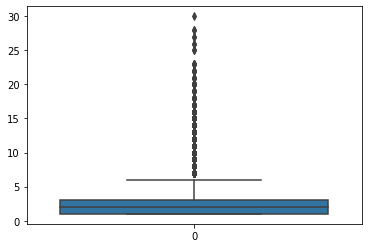

In [12]:
import seaborn as sns
sns.boxplot(data = session_length)

# 이상치 제거 고려해볼 것

In [13]:
long_session = session_length[session_length > 10].index[0]
long_session

5351

In [14]:
data = data.loc[data['SessionId'] != long_session]
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


In [15]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

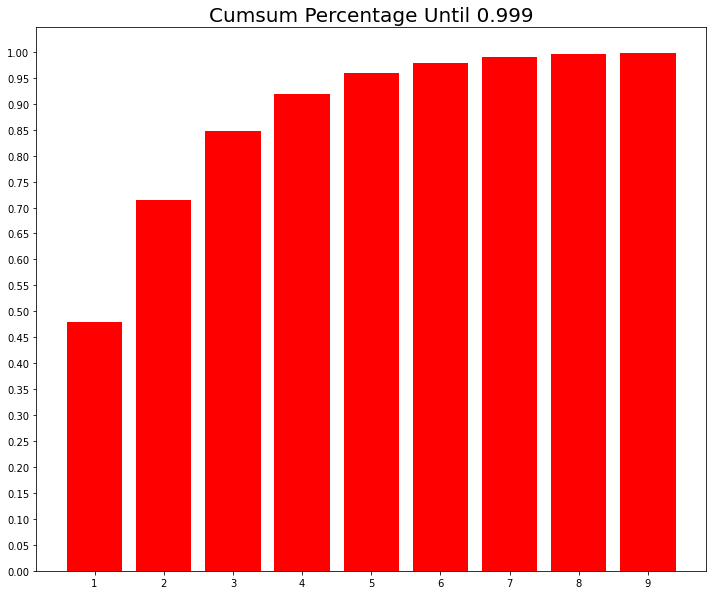

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 1-3 Session Time

Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있다. datetime을 통해 Time 컬럼을 바꿔준다.

In [17]:
date_string = '1970-01-01 00:00:00.000'
format_ = '%Y-%m-%d %H:%M:%S.%f'
dt_strptime = dt.datetime.strptime(date_string, format_)


In [18]:
from datetime import timedelta

date_string = '1970-01-01 00:00:00.000'
format_ = '%Y-%m-%d %H:%M:%S.%f'
dt_strptime = dt.datetime.strptime(date_string, format_)
date = []

for tm in data['Time'] :
    date.append(dt_strptime + timedelta(seconds = tm))

In [19]:
data['Time'] = date

data.head()

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2


(데이터를 전체 데이터로 수정)

In [20]:
# oldest, latest = data['Time'].min(), data['Time'].max()
# print(oldest) 
# print(latest)

In [21]:
# year_ago = latest - dt.timedelta(365*2)   
# data = data[data['Time'] > year_ago]
# data

### 1-4 Data Cleansing

Rating 중 평가가 부정적이라고 예상되는 1, 2에 해당되는 Rating은 제거해주었다.

In [22]:
data = data.loc[data['Rating'] >= 3]
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


### 1-5 Train / Valid / Test split

데이터셋은 가장 최근 데이터를 기준으로 100일 기간 동안을 Test, 그 전 100일 기간 동안을 Vaildation으로 나누었다.

In [23]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [24]:
tr, test = split_by_date(data, n_days = 100)
tr, val = split_by_date(tr, n_days=100)

In [25]:
# data에 대한 정보 확인
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [26]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 827981
	 Sessions: 417186
	 Items: 3623
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-08-12 13:53:29

* valid Set Stats Info
	 Events: 4363
	 Sessions: 3146
	 Items: 1727
	 First Time : 2002-08-13 00:40:06
	 Last Time : 2002-11-20 16:38:40

* test Set Stats Info
	 Events: 4118
	 Sessions: 3071
	 Items: 1625
	 First Time : 2002-11-20 20:30:02
	 Last Time : 2003-02-28 17:49:50



In [27]:
# train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [28]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

<hr>

## 2. Data Pipeline

### 2-1 Session Dataset

In [29]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [30]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,2000-12-31 22:00:19,0,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,4
5,1,1836,5,2000-12-31 22:02:52,3,5
6,1,3408,4,2000-12-31 22:04:35,4,6
7,1,2804,5,2000-12-31 22:11:59,5,7
8,1,1207,4,2000-12-31 22:11:59,5,8
9,1,1193,5,2000-12-31 22:12:40,6,9


In [31]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 827979, 827980, 827981], dtype=int32)

In [32]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 417183, 417184, 417185])

### 2-2 Session Data Loader

In [33]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size
    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished


In [34]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,2000-12-31 22:00:19,0,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,4
5,1,1836,5,2000-12-31 22:02:52,3,5
6,1,3408,4,2000-12-31 22:04:35,4,6
7,1,2804,5,2000-12-31 22:11:59,5,7
8,1,1207,4,2000-12-31 22:11:59,5,8
9,1,1193,5,2000-12-31 22:12:40,6,9


In [35]:
iter_ex = iter(tr_data_loader)

In [36]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


<hr>

## 3. Modeling

### 3-1 Evaluation metric

In [37]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 3-2 Model Architecture

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [39]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [40]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=40)

In [41]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3623)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    551250    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3623)               184773    
Total params: 736,023
Trainable params: 736,023
Non-trainable params: 0
_________________________________________________________________


### 3-3 Model Training

In [42]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [43]:
train_model(model, args)

Evaluation:  89%|████████▉ | 8/9 [00:08<00:01,  1.01s/it]


	 - Recall@40 epoch 1: 0.175781
	 - MRR@40    epoch 1: 0.035950



Evaluation:  89%|████████▉ | 8/9 [00:07<00:00,  1.08it/s]


	 - Recall@40 epoch 2: 0.249023
	 - MRR@40    epoch 2: 0.059881



Evaluation:  89%|████████▉ | 8/9 [00:07<00:00,  1.12it/s]


	 - Recall@40 epoch 3: 0.280273
	 - MRR@40    epoch 3: 0.069126



Evaluation:  89%|████████▉ | 8/9 [00:07<00:00,  1.13it/s]


	 - Recall@40 epoch 4: 0.294922
	 - MRR@40    epoch 4: 0.074188



Evaluation:  89%|████████▉ | 8/9 [00:07<00:00,  1.14it/s]


	 - Recall@40 epoch 5: 0.303711
	 - MRR@40    epoch 5: 0.077413



Evaluation:  89%|████████▉ | 8/9 [00:07<00:00,  1.13it/s]


	 - Recall@40 epoch 6: 0.291992
	 - MRR@40    epoch 6: 0.077834



Evaluation:  89%|████████▉ | 8/9 [00:07<00:00,  1.13it/s]


	 - Recall@40 epoch 7: 0.302734
	 - MRR@40    epoch 7: 0.077673



Evaluation:  89%|████████▉ | 8/9 [00:06<00:00,  1.15it/s]


	 - Recall@40 epoch 8: 0.305664
	 - MRR@40    epoch 8: 0.078413



Evaluation:  89%|████████▉ | 8/9 [00:07<00:00,  1.12it/s]


	 - Recall@40 epoch 9: 0.301758
	 - MRR@40    epoch 9: 0.078083



Evaluation:  89%|████████▉ | 8/9 [00:07<00:00,  1.11it/s]

	 - Recall@40 epoch 10: 0.297852
	 - MRR@40    epoch 10: 0.078123



In [44]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  88%|████████▊ | 7/8 [00:03<00:00,  1.93it/s]

	 - Recall@40: 0.267857
	 - MRR@40: 0.102345



## 결과 변화

### 1. 데이터셋 수정

**최근 데이터 기준 2년 동안 데이터**

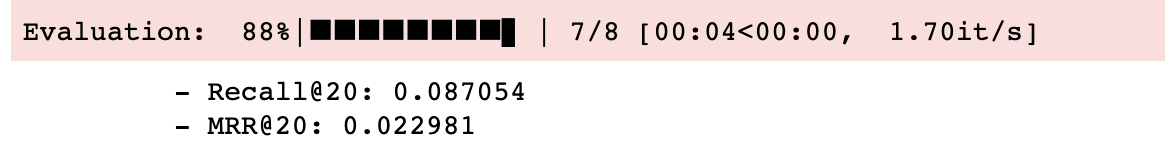

**수정) 최근 데이터 기준 2년 동안 데이터 -> 전체 데이터**

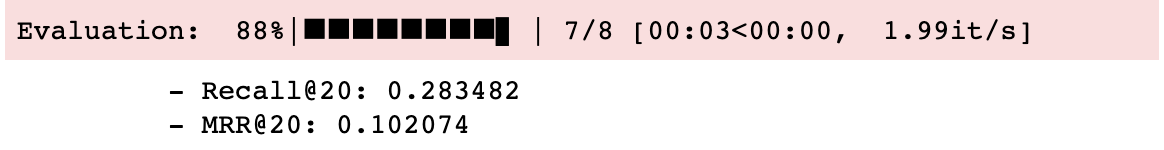

### 2. 이상치 제거

**전체 세션 중 99.9% 이외의 세션을 이상치로 판단하여 제거**

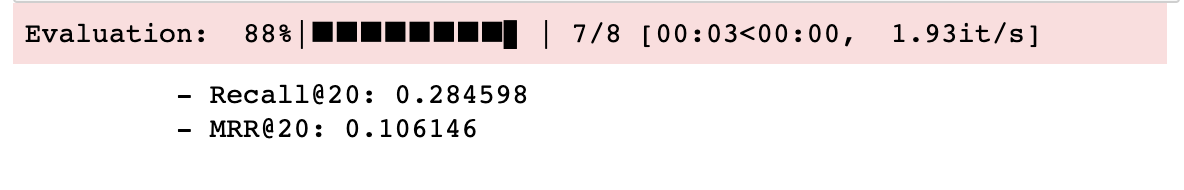

### 3. 하이퍼 파라미터 수정

**기존 : batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20**

**수정 1) batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20**

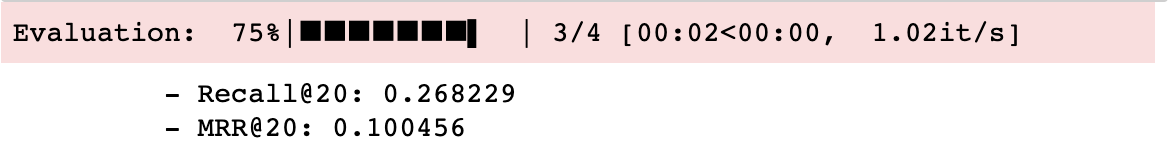

**수정 2) batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=30**

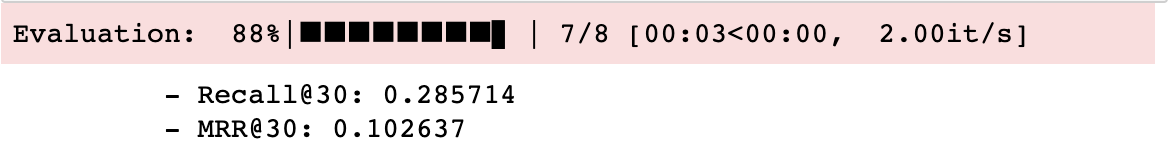

**수정 2) batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=40**

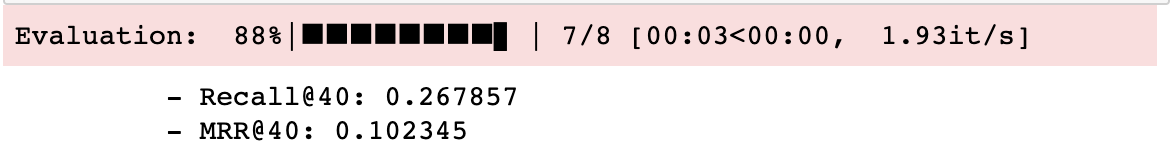

<hr>

## 프로젝트를 마치며

이번 프로젝트는 세션 데이터를 기반으로 사용자가 다음에 볼 영화를 예측하는 추천 시스템을 구현해보는 것이었다. 세션을 먼저 정의해 줄 필요가 있었는데, 사용자 ID와 Time(Date)을 고려하여 동일한 사용자의 동일한 시간을 구분하여 세션을 나누어주었다. 모델링은 가장 최근 데이터를 기준으로 2년 동안 기록된 데이터를 대상으로 처음에는 진행되었으나 성능 개선을 위해 전체 데이터를 사용하게 되었다. 데이터셋은 최근 데이터로 부터 100일 전까지 Test, 그 전 100일까지의 데이터는 Validation으로 사용하였다. 

2년동안의 데이터를 전체 데이터로 수정한 이유는 MRR이 약 0.02로 나왔기 때문이다. k값을 20으로 두었는데 MRR이 0.02라는 것은 추천 리스트 중 성공적인 추천이 없는 경우가 많았다는 의미로 생각했다. 전체 데이터를 사용하여 다시 학습한 결과, MRR이 0.1 이상으로 올랐다. 부족한 듯 했지만 Relevant Rank가 1/10보다 높았고 설정해둔 k값 안에는 어느 정도 Relevant Item이 나타난 것이라고 판단했다.

다음은 이상치를 제거해주었다. 데이터 전처리 과정에서 세션 길이를 확인하니 99.9%가 길이가 10이하로 나타났지만 길이가 30인 세션도 있었다. 세션 길이를 박스플롯으로 나타내어 보니 이상치라고 판단하기에는 박스 밖 분포가 너무 고르기도 했고 애매한 느낌이 있었다. 제거한다고 결과에 큰 영향을 줄 것 같지는 않아서 99.9%에 해당되지 않는 길이가 10초과인 세션들을 제거해주었다. Recall과 MRR 모두 약간의 상승을 보였다.

하이퍼 파라미터도 수정해보았다. 처음에는 batch_size를 128에서 256으로 수정해보았다. Recall과 MRR 모두 수정 전보다 떨어지는 것을 확인했다. 다시 batch_size는 128로 수정하고 이번에는 k를 30과 40으로 수정해주었다. 사실 k값을 높인다는 것은 그만큼 추천해주는 아이템이 많아진다는 것이기 때문에 얼마나 잘 맞췄는지를 의미하는 Recall이 당연히 높아질 것이라고 예상했다. 하지만 k=30일 때에는 Recall값이 훈련시킨 모델 중 가장 높게 나왔고, 오히려 k=40일 때 다시 Recall값이 떨어지는 것을 확인했다. 원인에 대해서는 조금 더 연구해볼 필요가 있어 보인다.

여러 시도 끝에 결국 Recall값은 대략 0.285, MRR은 대략 0.106 정도가 최선이었던 것 같다. 수치로 보면 높은 숫자는 아니기에 과연 성능이 좋은 모델이라고 할 수 있을지는 모르겠다. 프로젝트를 마치면서 문득 들었던 생각은 데이터셋을 나누는 과정에서 시간을 기준으로 나누었던 것이 과연 옳은 선택이었나 였다. 특히나 영화 같은 아이템은 시간에 따라 상영하는 영화들도 다르고 유행하는 장르도 다르기 때문이다. 데이터셋을 나누는 과정을 시간에 따라서가 아닌 랜덤으로 섞은 후 공평하게 나누는 층화추출이 더 적절하지 않을까? 나중에 직접 시도해봐야겠다.